In [1]:
# To begin using librosa we need to import it, and other tools such as matplotlib and numpy
from __future__ import print_function # use the print() function from Python3
from operator import add
from pylab import *
import librosa             # The librosa library
import librosa.display     # librosa's display module (for plotting features)
import IPython.display     # IPython's display module (for in-line audio)
import matplotlib.pyplot as plt # matplotlib plotting functions
import matplotlib.style as ms   # plotting style
import numpy as np              # numpy numerical functions
ms.use('seaborn-muted')         # fancy plot designs
import soundfile as sf
from numpy import random
from scipy import signal
import matplotlib.pyplot as plt
from statistics import mean 
import librosa
import scipy.io.wavfile as wavf
import pandas as pd
from tree_lib import *

In [3]:
df = pd.read_csv("Partial_Data.csv")

In [4]:
df.describe()

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,cont_rating
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,105.714993,1234.519801,157.748602,2675.674535,269.391269,25.96800
std,56.063848,418.906830,84.727639,730.646550,194.135197,22.33187
min,0.000000,293.271704,25.089252,442.187500,0.620617,0.00000
25%,58.593750,892.096906,98.407200,2123.582945,141.133054,10.00000
50%,117.187500,1269.334969,137.021202,2852.027926,225.442490,20.00000
75%,117.187500,1612.315401,194.398112,3263.277095,357.145803,40.00000
max,312.500000,1960.290305,726.057245,3932.995346,1564.872757,100.00000


In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,cont_rating
tempo,1,-0.0660366,0.0268444,-0.040319,0.0315801,0.0486628
avg_cent,-0.0660366,1,0.110479,0.937428,-0.316228,0.012012
std_cent,0.0268444,0.110479,1,0.101813,0.735518,0.394314
avg_rolloff,-0.040319,0.937428,0.101813,1,-0.295131,-0.00792118
std_rolloff,0.0315801,-0.316228,0.735518,-0.295131,1,0.263259
cont_rating,0.0486628,0.012012,0.394314,-0.00792118,0.263259,1


In [8]:
df.head()

,expression,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,cont_rating
0,(t^(t|11))^((t*12)&11),0.0,1423.748379,28.975580,2505.219415,10.470544,0
1,t*(t/10),0.0,1798.640484,124.706192,3310.422207,110.661750,5
2,(t|(t&7))*(t/8),0.0,1793.097701,110.199590,3311.668883,102.001201,5
3,((t>>6)-(t^((t>>1)|5)))-((t>>4)&5),0.0,902.329811,73.414003,2299.301862,203.824060,10
4,(t*((3+(1^((t>>10)&5)))*(5+(3&(t>>14)))))>>((t...,0.0,1179.234930,113.366500,2697.406915,157.340452,60


In [9]:
expressions = df["expression"]
render_tups = render(expressions, 8000, 30)
renderings = render_tups[0]

In [60]:
expression_testing = []

In [61]:
for i in range(len(expressions)):
    print(i)
    y = np.array(renderings[i], dtype = 'f')
    sr = 8000
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    o_env = librosa.onset.onset_strength(y, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    intervals = [times[0]]
    for i in range(1,len(times)):
        intervals.append(times[i] - times[i-1])
        

    shift_y = y - np.median(y)
    z_cross = librosa.feature.zero_crossing_rate(shift_y)
    avg_zcross = z_cross.mean()
    std_zcross = np.std(z_cross)
    
    flatness = librosa.feature.spectral_flatness(y=y)
    avg_flt = flatness.mean()
    std_flt = np.std(flatness)
    
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    avg_bw = spec_bw.mean()
    
    spec_ctr = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4)
    avg_ctr = spec_ctr.mean()
    std_ctr = np.std(spec_ctr)
    
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    avg_cent = cent.mean()
    std_cent = np.std(cent)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    avg_rolloff = rolloff.mean()
    std_rolloff = np.std(rolloff)
    
    
    expression_testing.append([expressions[i], tempo, avg_cent, std_cent, avg_rolloff, std_rolloff, avg_zcross, std_zcross, avg_flt, std_flt, avg_bw, avg_ctr, std_ctr])
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [417]:
df = pd.DataFrame(expression_testing, columns = ['expression', 'tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr'])
df["cont_rating"] = pd.read_csv("Partial_Data.csv")["cont_rating"]


In [418]:
df

,expression,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating
0,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.000000,1421.697521,19.049015,2504.439299,6.771271,0.623013,0.018510,0.000005,0.000068,1346.582751,89.023430,29.524912,0
1,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.000000,1797.760567,123.762959,3309.909715,110.296631,0.498658,0.056105,0.080754,0.012509,1247.929395,19.277228,6.044784,5
2,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.000000,1793.711222,109.706648,3312.150187,101.736015,0.498456,0.015501,0.058042,0.001381,1256.296637,25.695953,9.577911,5
3,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.000000,904.023720,73.802001,2301.714086,205.103983,0.030035,0.003914,0.011143,0.002382,1098.540840,17.823782,5.596369,10
4,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.000000,1180.065108,113.527747,2695.687300,154.794901,0.127081,0.045806,0.016274,0.002991,1164.376975,21.617211,4.126512,60
5,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,58.593750,1179.359121,326.290256,2632.520989,649.970672,0.205710,0.124355,0.003236,0.003019,1213.713700,38.249148,25.420969,45
6,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,14.648438,1000.655447,425.457014,2652.685235,1193.670000,0.317499,0.245965,0.010781,0.102692,1164.140234,44.011435,31.788373,10
7,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,14.648438,1652.503217,141.934450,3645.522388,104.938038,0.000000,0.000000,0.000383,0.001792,1509.774956,71.989216,15.206693,10
8,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,15.120968,1232.778467,226.033797,2700.334821,280.987964,0.120822,0.062164,0.009894,0.010440,1136.945673,53.280844,34.626957,90
9,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,17.045455,1587.033327,139.395838,3346.048774,211.966199,0.513928,0.015297,0.003115,0.003188,1334.982085,26.567432,7.162047,5


In [419]:
df.describe()

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,107.422192,1231.366877,161.039516,2670.394823,276.550810,0.209292,0.059216,0.023655,0.016272,1184.198224,27.276431,10.801359,25.96800
std,55.105890,419.668894,89.404021,732.997280,206.318038,0.197608,0.069631,0.054196,0.040363,170.682077,12.225157,8.409763,22.33187
min,0.000000,290.254346,19.049015,437.966418,0.568199,0.000000,0.000000,0.000004,0.000050,724.223904,7.084280,2.487334,0.00000
25%,58.593750,878.313755,98.373196,2069.121469,145.476409,0.021105,0.008018,0.001827,0.001907,1028.881197,20.123950,5.502598,10.00000
50%,117.187500,1257.083131,141.167250,2838.827625,236.516551,0.141034,0.030514,0.005650,0.003886,1204.606387,23.807866,7.084626,20.00000
75%,117.187500,1601.738480,192.760365,3257.308602,359.145083,0.377049,0.087477,0.020248,0.011146,1292.512194,29.840618,11.310720,40.00000
max,312.500000,1966.691888,726.703211,3932.744203,1510.743345,0.911439,0.320385,0.563939,0.466523,1703.734255,89.023430,35.873483,100.00000


In [420]:

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating
tempo,1,-0.0662399,0.00862328,-0.0409294,0.0199292,-0.11699,-0.0951539,0.0151707,0.0105295,-0.0398637,-0.0900583,-0.0617548,0.0350009
avg_cent,-0.0662399,1,0.0785685,0.938303,-0.32461,0.626425,0.337392,0.327932,0.093425,0.807858,-0.0663625,-0.153615,0.0141911
std_cent,0.00862328,0.0785685,1,0.0746486,0.770227,0.0992807,0.522163,0.0905418,0.397283,0.0693815,0.124558,0.256649,0.398118
avg_rolloff,-0.0409294,0.938303,0.0746486,1,-0.302196,0.609905,0.320147,0.237224,0.0636717,0.925141,-0.00241463,-0.11123,-0.00879994
std_rolloff,0.0199292,-0.32461,0.770227,-0.302196,1,-0.165077,0.271605,0.00314189,0.356828,-0.241906,0.0886249,0.283069,0.272867
avg_zcross,-0.11699,0.626425,0.0992807,0.609905,-0.165077,1,0.605025,-0.0808317,-0.111274,0.645032,0.00123173,-0.000199575,-0.0433705
std_zcross,-0.0951539,0.337392,0.522163,0.320147,0.271605,0.605025,1,-0.0995137,0.0119697,0.330471,0.0645625,0.119172,0.273221
avg_flt,0.0151707,0.327932,0.0905418,0.237224,0.00314189,-0.0808317,-0.0995137,1,0.571646,0.0601428,-0.2508,-0.18769,-0.00978411
std_flt,0.0105295,0.093425,0.397283,0.0636717,0.356828,-0.111274,0.0119697,0.571646,1,-0.0587292,-0.0502329,0.110496,0.253035
avg_bw,-0.0398637,0.807858,0.0693815,0.925141,-0.241906,0.645032,0.330471,0.0601428,-0.0587292,1,0.0533332,-0.0714993,-0.0738223


In [421]:
df2 = df

In [433]:
df2.describe()
df2.to_csv("spectral_data2.csv")

In [637]:
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,Unnamed: 0.1,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating
Unnamed: 0,1,1,0.572389,0.00632937,0.0220846,0.0316732,0.0217512,-0.0298675,-0.0898983,0.0524807,0.0453082,0.0288197,-0.0787739,-0.042693,0.0347176
Unnamed: 0.1,1,1,0.572389,0.00632937,0.0220846,0.0316732,0.0217512,-0.0298675,-0.0898983,0.0524807,0.0453082,0.0288197,-0.0787739,-0.042693,0.0347176
tempo,0.572389,0.572389,1,-0.0662399,0.00862328,-0.0409294,0.0199292,-0.11699,-0.0951539,0.0151707,0.0105295,-0.0398637,-0.0900583,-0.0617548,0.0350009
avg_cent,0.00632937,0.00632937,-0.0662399,1,0.0785685,0.938303,-0.32461,0.626425,0.337392,0.327932,0.093425,0.807858,-0.0663625,-0.153615,0.0141911
std_cent,0.0220846,0.0220846,0.00862328,0.0785685,1,0.0746486,0.770227,0.0992807,0.522163,0.0905418,0.397283,0.0693815,0.124558,0.256649,0.398118
avg_rolloff,0.0316732,0.0316732,-0.0409294,0.938303,0.0746486,1,-0.302196,0.609905,0.320147,0.237224,0.0636717,0.925141,-0.00241463,-0.11123,-0.00879994
std_rolloff,0.0217512,0.0217512,0.0199292,-0.32461,0.770227,-0.302196,1,-0.165077,0.271605,0.00314189,0.356828,-0.241906,0.0886249,0.283069,0.272867
avg_zcross,-0.0298675,-0.0298675,-0.11699,0.626425,0.0992807,0.609905,-0.165077,1,0.605025,-0.0808317,-0.111274,0.645032,0.00123173,-0.000199575,-0.0433705
std_zcross,-0.0898983,-0.0898983,-0.0951539,0.337392,0.522163,0.320147,0.271605,0.605025,1,-0.0995137,0.0119697,0.330471,0.0645625,0.119172,0.273221
avg_flt,0.0524807,0.0524807,0.0151707,0.327932,0.0905418,0.237224,0.00314189,-0.0808317,-0.0995137,1,0.571646,0.0601428,-0.2508,-0.18769,-0.00978411


In [1375]:
from sklearn import preprocessing



In [1403]:
df2 = pd.read_csv("spectral_data2.csv")
X = df2[['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr']]
y = df2["cont_rating"]

In [1404]:
#X = df2[["std_cent", "std_rolloff", "std_zcross", "std_flt", "avg_bw", "avg_ctr", "std_ctr"]]
#y = df2["cont_rating"]

In [1405]:
import torch

dtype = torch.float
device = torch.device("cpu")

N, D_in, H, D_out = 500, 12, 10, 1 #4

train_size = 400
test_size = N - train_size

x = torch.from_numpy(np.array(X, dtype = 'f')).float()
y = torch.from_numpy(np.expand_dims(np.array(y, dtype = 'f'),axis=1)).float()


In [1406]:
print(y.size())
print(x.size())
print(train_size)
print(test_size)

torch.Size([500, 1])
torch.Size([500, 12])
400
100


In [1407]:
for H in range(8,9):
    N, D_in, H1, H2, D_out = 500, 12, H, 2, 1 #4
    t_loss = []
    v_loss = []
    for i in range(2):
        loss_dic = {'train': [], 'validation': []}

        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H1, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, H2, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H2, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        #mse = torch.nn.MSELoss(reduction='sum')
        l1 = torch.nn.L1Loss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        for t in range(10000):

            y_pred = model(X_train)

            #loss = mse(y_pred, y_train)
            loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            #loss_validation = mse(y_validation_pred, y_test)
            loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
                #print(t, loss.item() / train_size, loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    print("%d: Test loss: %d ~ %d, Val loss: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

8: Test loss: 17 ~ 0, Val loss: 17 ~ 0


In [1408]:
for H in range(11,13):
    N, D_in, H, D_out = 500, 12, H, 1 #4
    t_loss = []
    v_loss = []
    for i in range(5):
        loss_dic = {'train': [], 'validation': []}

        train_dataset, test_dataset = torch.utils.data.random_split(torch.cat((x, y), 1), [train_size, test_size])
        X_train = train_dataset.dataset[train_dataset.indices][:, :D_in]
        X_test = test_dataset.dataset[test_dataset.indices][:, :D_in]
        y_train = train_dataset.dataset[train_dataset.indices][:, D_in: D_in + D_out]
        y_test = test_dataset.dataset[test_dataset.indices][:, D_in:D_in + D_out]

        scaler = preprocessing.StandardScaler()
        X_train = torch.from_numpy(scaler.fit_transform(X_train.numpy()))
        X_test = torch.from_numpy(scaler.transform(X_test.numpy()))

        model = torch.nn.Sequential(
            torch.nn.Linear(D_in, H, bias=False),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out, bias=False),
        )

        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)


        #mse = torch.nn.MSELoss(reduction='sum')
        l1 = torch.nn.L1Loss(reduction='sum')
        
        learning_rate = 1e-6
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        loss_dic['train'] = []
        loss_dic['validation'] = []
        torch.nn.init.normal_(model[0].weight)
        torch.nn.init.normal_(model[2].weight)
        for t in range(10000):

            y_pred = model(X_train)

            #loss = mse(y_pred, y_train)
            loss = l1(y_pred, y_train)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_validation_pred = model(X_test)

            #loss_validation = mse(y_validation_pred, y_test)
            loss_validation = l1(y_validation_pred, y_test)
            
            loss_dic['train'].append(loss / train_size)
            loss_dic['validation'].append(loss_validation / test_size)

            if t == 9999:
                t_loss.append(loss.item() / train_size)
                v_loss.append(loss_validation.item() / test_size)
                #print(t, loss.item() / train_size, loss_validation.item() / test_size)
    v_loss = np.array(v_loss)
    t_loss = np.array(t_loss)
    print("%d: Test loss: %d ~ %d, Val loss: %d ~ %d" % (H, t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

11: Test loss: 16 ~ 0, Val loss: 16 ~ 1
12: Test loss: 16 ~ 0, Val loss: 15 ~ 1


In [1409]:
v_loss = np.array(v_loss)
t_loss = np.array(t_loss)
print("Test loss: %d ~ %d, Val loss: %d ~ %d" % (t_loss.mean(), np.std(t_loss), v_loss.mean(), np.std(v_loss)))

Test loss: 16 ~ 0, Val loss: 15 ~ 1


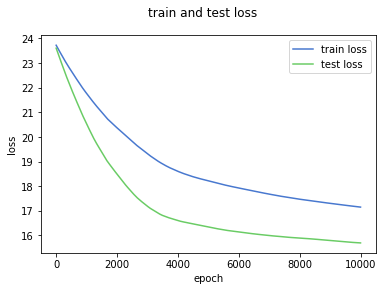

In [1410]:
plt.plot([x for x in range(10000)], loss_dic['train'], label = "train loss")
plt.plot([x for x in range(10000)], loss_dic['validation'], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.suptitle("train and test loss")
plt.legend();

In [1411]:
y_validation_pred = model(X_test)

In [1412]:
df2 = pd.read_csv("spectral_data2.csv")
X = df2[['tempo', 'avg_cent', 'std_cent', 'avg_rolloff', 'std_rolloff', 'avg_zcross', 'std_zcross', 'avg_flt', 'std_flt', 'avg_bw', 'avg_ctr', 'std_ctr']]
y = df2["cont_rating"]

In [1413]:
y_pred = model(torch.from_numpy(scaler.transform(np.array(X, dtype = 'f'))))

In [1414]:
y_pred.detach().numpy()

array([[13.773694 ],
       [ 2.8511522],
       [ 5.333805 ],
       [11.650895 ],
       [ 8.57319  ],
       [28.338211 ],
       [55.87233  ],
       [14.961466 ],
       [26.139137 ],
       [ 9.30669  ],
       [ 4.902116 ],
       [15.671881 ],
       [14.238688 ],
       [18.326725 ],
       [28.888802 ],
       [13.798259 ],
       [14.76633  ],
       [18.96753  ],
       [15.018496 ],
       [ 8.788188 ],
       [11.89522  ],
       [33.003124 ],
       [19.889858 ],
       [17.456799 ],
       [13.392496 ],
       [17.419195 ],
       [36.806377 ],
       [24.904966 ],
       [19.493612 ],
       [13.8859215],
       [22.926458 ],
       [20.950525 ],
       [27.030462 ],
       [23.204334 ],
       [41.624336 ],
       [13.969383 ],
       [28.320728 ],
       [72.25565  ],
       [14.928381 ],
       [11.029606 ],
       [10.195906 ],
       [14.304537 ],
       [15.668766 ],
       [ 9.890269 ],
       [13.029892 ],
       [ 2.2338643],
       [ 4.053148 ],
       [14.60

In [1415]:
df2["y_pred"] = y_pred.detach().numpy()

In [1416]:
df2.describe()


,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating,y_pred
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,107.422192,1231.366877,161.039516,2670.394823,276.550810,0.209292,0.059216,0.023655,0.016272,1184.198224,27.276431,10.801359,25.96800,17.234880
std,55.105890,419.668894,89.404021,732.997280,206.318038,0.197608,0.069631,0.054196,0.040363,170.682077,12.225157,8.409763,22.33187,10.049328
min,0.000000,290.254346,19.049015,437.966418,0.568199,0.000000,0.000000,0.000004,0.000049,724.223904,7.084280,2.487334,0.00000,2.233864
25%,58.593750,878.313755,98.373196,2069.121469,145.476409,0.021105,0.008018,0.001827,0.001907,1028.881197,20.123950,5.502598,10.00000,11.072306
50%,117.187500,1257.083132,141.167250,2838.827625,236.516551,0.141034,0.030514,0.005650,0.003886,1204.606387,23.807866,7.084626,20.00000,14.815850
75%,117.187500,1601.738480,192.760365,3257.308602,359.145083,0.377049,0.087477,0.020248,0.011146,1292.512194,29.840618,11.310720,40.00000,20.650991
max,312.500000,1966.691888,726.703211,3932.744203,1510.743345,0.911439,0.320385,0.563939,0.466523,1703.734255,89.023430,35.873483,100.00000,90.001167


In [1417]:
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm')

,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating,y_pred
tempo,1,-0.0662399,0.00862328,-0.0409294,0.0199292,-0.11699,-0.0951539,0.0151707,0.0105295,-0.0398637,-0.0900583,-0.0617548,0.0350009,0.138114
avg_cent,-0.0662399,1,0.0785685,0.938303,-0.32461,0.626425,0.337392,0.327932,0.093425,0.807858,-0.0663625,-0.153615,0.0141911,-0.106301
std_cent,0.00862328,0.0785685,1,0.0746486,0.770227,0.0992807,0.522163,0.0905418,0.397283,0.0693815,0.124558,0.256649,0.398118,0.709298
avg_rolloff,-0.0409294,0.938303,0.0746486,1,-0.302196,0.609905,0.320147,0.237224,0.0636717,0.925141,-0.00241463,-0.11123,-0.00879994,-0.104732
std_rolloff,0.0199292,-0.32461,0.770227,-0.302196,1,-0.165077,0.271605,0.00314188,0.356828,-0.241906,0.0886249,0.283069,0.272867,0.649129
avg_zcross,-0.11699,0.626425,0.0992807,0.609905,-0.165077,1,0.605025,-0.0808317,-0.111274,0.645032,0.00123173,-0.000199575,-0.0433705,-0.0255918
std_zcross,-0.0951539,0.337392,0.522163,0.320147,0.271605,0.605025,1,-0.0995137,0.0119697,0.330471,0.0645625,0.119172,0.273221,0.421951
avg_flt,0.0151707,0.327932,0.0905418,0.237224,0.00314188,-0.0808317,-0.0995137,1,0.571646,0.0601428,-0.2508,-0.18769,-0.00978411,0.135237
std_flt,0.0105295,0.093425,0.397283,0.0636717,0.356828,-0.111274,0.0119697,0.571646,1,-0.0587292,-0.0502329,0.110496,0.253035,0.518053
avg_bw,-0.0398637,0.807858,0.0693815,0.925141,-0.241906,0.645032,0.330471,0.0601428,-0.0587292,1,0.0533332,-0.0714993,-0.0738223,-0.0719981


In [1418]:
df2.head()

,expression,tempo,avg_cent,std_cent,avg_rolloff,std_rolloff,avg_zcross,std_zcross,avg_flt,std_flt,avg_bw,avg_ctr,std_ctr,cont_rating,y_pred
0,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.0,1421.697521,19.049015,2504.439299,6.771271,0.623013,0.018510,0.000005,0.000068,1346.582751,89.023430,29.524912,0,13.773694
1,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.0,1797.760567,123.762959,3309.909715,110.296631,0.498658,0.056105,0.080754,0.012509,1247.929395,19.277228,6.044784,5,2.851152
2,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.0,1793.711222,109.706648,3312.150187,101.736015,0.498456,0.015501,0.058042,0.001381,1256.296637,25.695953,9.577911,5,5.333805
3,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.0,904.023720,73.802001,2301.714086,205.103983,0.030035,0.003914,0.011143,0.002382,1098.540840,17.823782,5.596369,10,11.650895
4,(t>>8)&(((t>>11)&(t+(t*10)))|(((t|11)&9)^((t*(...,0.0,1180.065108,113.527748,2695.687300,154.794901,0.127081,0.045806,0.016274,0.002991,1164.376975,21.617211,4.126512,60,8.573190
